### **Importing necessary dependencies**

In [ ]:
import datetime as dt
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
from random import choice, randint
import scipy.stats as scs
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")

### **Loading the data**

In [ ]:
data = pd.read_csv(filepath_or_buffer="interstate_traffic.csv", sep=",")
data.shape

(48204, 9)

In [ ]:
data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Renaming columns**

In [ ]:
data.rename(
    columns={
        "rain_1h": "rain",
        "snow_1h": "snow",
        "clouds_all": "cloud",
        "weather_main": "weather",
        "traffic_volume": "traffic"
    },
    inplace=True
)

In [ ]:
data.head(5)

,holiday,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Checking for null values**

In [ ]:
data.isnull().sum()

,0
holiday,48143
temp,0
rain,0
snow,0
cloud,0
weather,0
weather_description,0
date_time,0
traffic,0


### **Dropping the holiday column as it is entirely sparse**

In [ ]:
data.drop('holiday', inplace=True, axis=1)

In [ ]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Encoding the categorical variables**

In [ ]:
label_encoder = LabelEncoder()
data['weather'] = label_encoder.fit_transform(data['weather'])
data['weather_description'] = label_encoder.fit_transform(data['weather_description'])

In [ ]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


### **Plotting the correlation between all the variables**

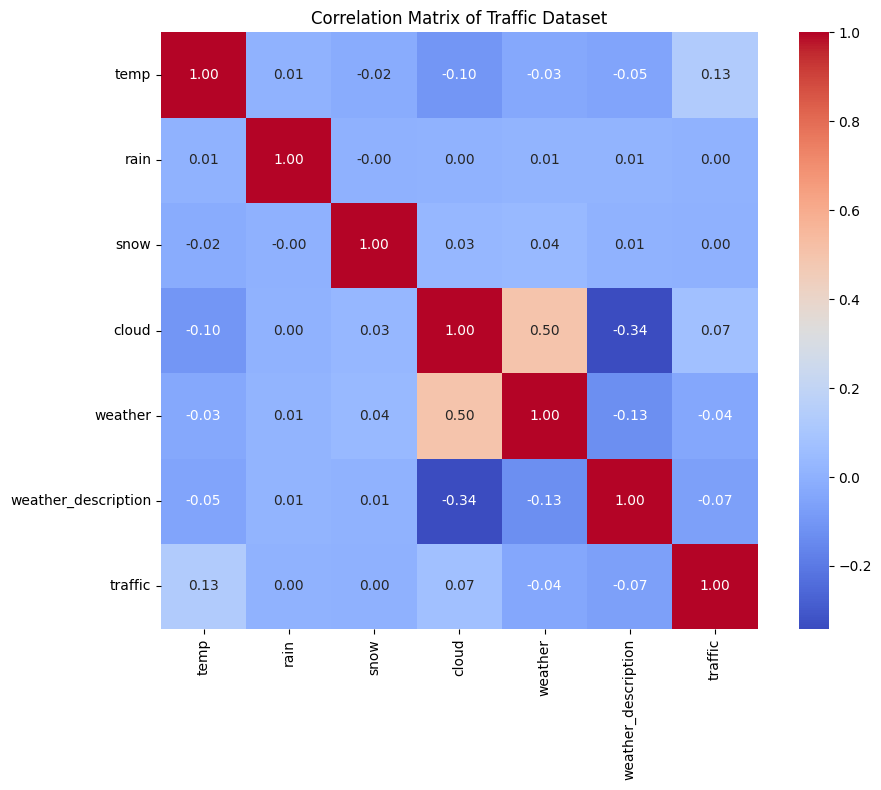

In [ ]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Traffic Dataset")
plt.tight_layout()
plt.show()

### **As we can see there is very little correlation between traffic and all the other variables**

### **Hence we perform PCA**

In [ ]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


In [ ]:
features = ['temp', 'rain', 'snow', 'cloud', 'weather', 'weather_description']
X = data[features]

### **Scaling the values (necessary for PCA)**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Creating two new components**

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['traffic'] = data['traffic'].values

### **Plotting the components**

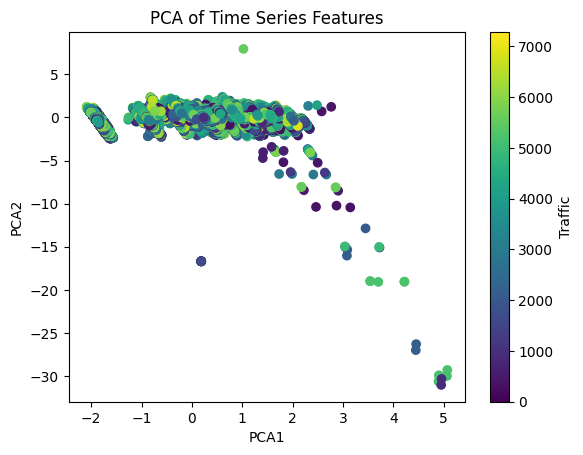

In [ ]:
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['traffic'], cmap='viridis')
plt.colorbar(label='Traffic')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Time Series Features')
plt.show()

### **Checking the correlation b/w the principle components and traffic**

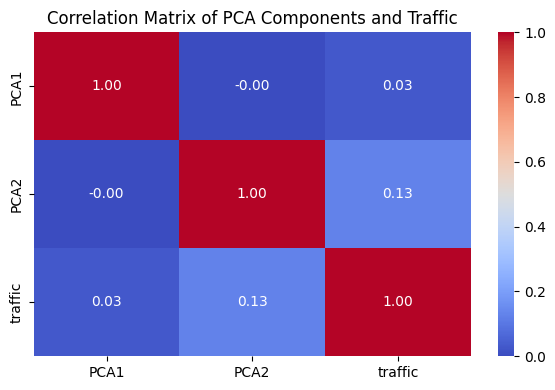

In [ ]:
corr_matrix = pca_df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of PCA Components and Traffic")
plt.tight_layout()
plt.show()

### **Since the correlation between the principle components and traffic is not that high, autoregression is the best option available**

In [ ]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


In [ ]:
auto_reg_data = data[['date_time', 'traffic']]
auto_reg_data

,date_time,traffic
0,2012-10-02 09:00:00,5545
1,2012-10-02 10:00:00,4516
2,2012-10-02 11:00:00,4767
3,2012-10-02 12:00:00,5026
4,2012-10-02 13:00:00,4918
...,...,...
48199,2018-09-30 19:00:00,3543
48200,2018-09-30 20:00:00,2781
48201,2018-09-30 21:00:00,2159
48202,2018-09-30 22:00:00,1450


Text(0.5, 1.0, 'Distribution of Traffic Volume')

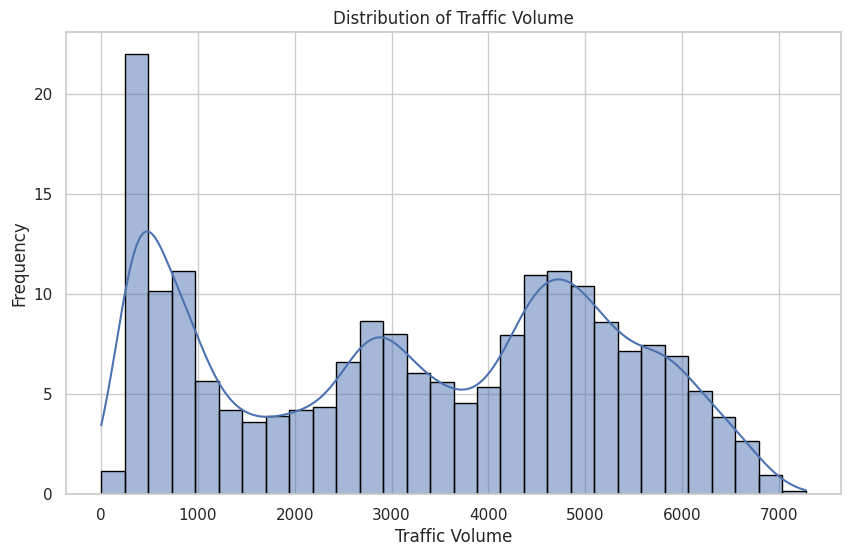

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=auto_reg_data, x='traffic', kde=True, stat='frequency', bins=30, edgecolor='black')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Volume')

In [ ]:
auto_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  48204 non-null  object
 1   traffic    48204 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 753.3+ KB


### **Converting the date time column into the proper format and setting it as the index**

In [ ]:
auto_reg_data['date_time'] = pd.to_datetime(auto_reg_data['date_time'])
auto_reg_data.set_index('date_time', inplace=True)

In [ ]:
auto_reg_data.head(5)

,traffic
date_time,
2012-10-02 09:00:00,5545
2012-10-02 10:00:00,4516
2012-10-02 11:00:00,4767
2012-10-02 12:00:00,5026
2012-10-02 13:00:00,4918


In [ ]:
auto_reg_data.shape

(48204, 1)

### **Plotting the autocorrelation matrix**

<Figure size 1000x600 with 0 Axes>

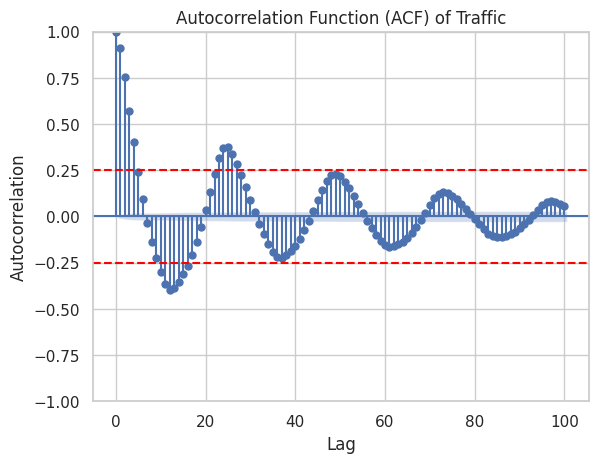

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(auto_reg_data['traffic'], lags=100)
plt.axhline(y=0.25, color='red', linestyle='--', label='Threshold (0.5)')
plt.axhline(y=-0.25, color='red', linestyle='--')
plt.title('Autocorrelation Function (ACF) of Traffic')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

### **We can build a model using the last 8 lags**

### **Preparing Data for XGBoost, SVR, RandomForest, GradientBoosting, and LGBM Models**

In [ ]:
def create_sequences(data, n_lags):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:(i + n_lags)])
        y.append(data[i + n_lags])
    return np.array(X), np.array(y)

In [ ]:
n_lags = 8
values = auto_reg_data['traffic'].values

In [ ]:
X, y = create_sequences(values, n_lags)

In [ ]:
X_flattened = X.reshape(X.shape[0], -1)

In [ ]:
train_size = int(len(X_flattened) * 0.7)
val_size = int(len(X_flattened) * 0.2)
test_size = len(X_flattened) - train_size - val_size

In [ ]:
X_train, X_val, X_test = X_flattened[:train_size], X_flattened[train_size:(train_size + val_size)], X_flattened[(train_size + val_size):]
y_train, y_val, y_test = y[:train_size], y[train_size:(train_size + val_size)], y[(train_size + val_size):]


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

### **Defining and Training the Models**

In [ ]:
models = {
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42)
}

In [ ]:
val_losses = {}

In [ ]:
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    # Train the model on the training set
    model.fit(X_train_scaled, y_train_scaled)

    # Compute validation loss (MSE)
    y_val_pred_scaled = model.predict(X_val_scaled)
    val_mse = np.mean((y_val_scaled - y_val_pred_scaled) ** 2)
    val_losses[model_name] = val_mse
    print(f"{model_name} Validation MSE: {val_mse:.6f}")


Training XGBoost...
XGBoost Validation MSE: 0.002924

Training SVR...
SVR Validation MSE: 0.003837

Training RandomForest...
RandomForest Validation MSE: 0.002814

Training GradientBoosting...
GradientBoosting Validation MSE: 0.003554

Training LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 33737, number of used features: 8
[LightGBM] [Info] Start training from score 0.445035
LGBM Validation MSE: 0.002903


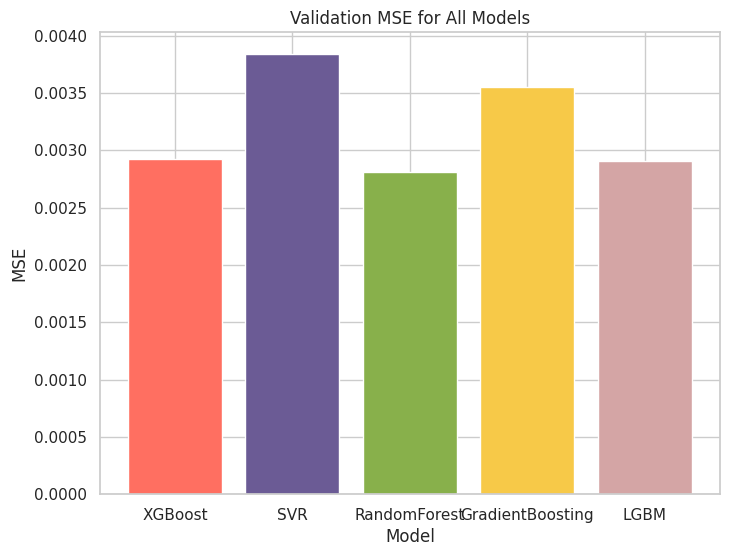

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(val_losses.keys(), val_losses.values(), color=['#FF6F61', '#6B5B95', '#88B04B', '#F7C948', '#D4A5A5'])
plt.title('Validation MSE for All Models')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

### **Test set evaluation**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [ ]:
metrics = {
    'MSE': {},
    'MAE': {},
    'RMSE': {},
    'MAPE': {}
}

In [ ]:
for model_name, model in models.items():
    # Predict on the test set
    predictions_scaled = model.predict(X_test_scaled)
    true_values_scaled = y_test_scaled

    # Inverse transform the predictions and true values to the original scale
    predictions_original = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()
    true_values_original = scaler_y.inverse_transform(true_values_scaled.reshape(-1, 1)).ravel()

    # Compute metrics
    mse = np.mean((true_values_original - predictions_original) ** 2)
    mae = np.mean(np.abs(true_values_original - predictions_original))
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_values_original, predictions_original)

    # Store metrics
    metrics['MSE'][model_name] = mse
    metrics['MAE'][model_name] = mae
    metrics['RMSE'][model_name] = rmse
    metrics['MAPE'][model_name] = mape

    print(f"\n{model_name} Test Metrics (Original Scale):")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.6f}%")


XGBoost Test Metrics (Original Scale):
MSE: 161079.286672
MAE: 258.615915
RMSE: 401.346841
MAPE: 12.452630%

SVR Test Metrics (Original Scale):
MSE: 200588.883910
MAE: 340.433755
RMSE: 447.871504
MAPE: 24.048850%

RandomForest Test Metrics (Original Scale):
MSE: 154804.300881
MAE: 251.138765
RMSE: 393.451777
MAPE: 11.815806%

GradientBoosting Test Metrics (Original Scale):
MSE: 184745.642579
MAE: 296.263771
RMSE: 429.820477
MAPE: 15.246642%

LGBM Test Metrics (Original Scale):
MSE: 152882.187807
MAE: 258.937709
RMSE: 391.001519
MAPE: 12.875671%


In [ ]:
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df[['XGBoost', 'SVR', 'RandomForest', 'GradientBoosting', 'LGBM']]
print("\nTest Metrics Table (Original Scale):")
print(metrics_df.round(6))


Test Metrics Table (Original Scale):
            XGBoost            SVR   RandomForest  GradientBoosting  \
MSE   161079.286672  200588.883910  154804.300881     184745.642579   
MAE      258.615915     340.433755     251.138765        296.263771   
RMSE     401.346841     447.871504     393.451777        429.820477   
MAPE      12.452630      24.048850      11.815806         15.246642   

               LGBM  
MSE   152882.187807  
MAE      258.937709  
RMSE     391.001519  
MAPE      12.875671  


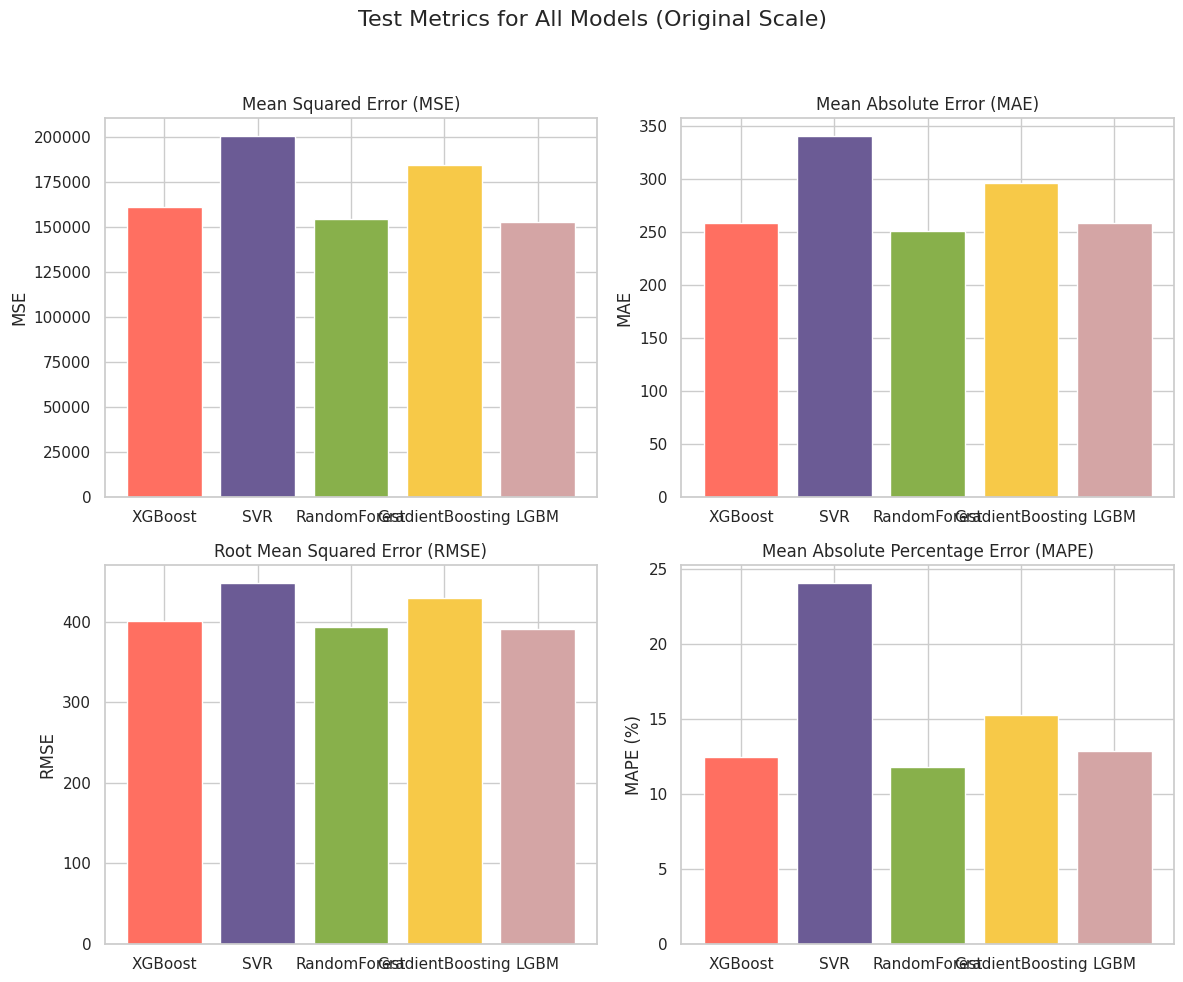

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Test Metrics for All Models (Original Scale)', fontsize=16)

# MSE
axes[0, 0].bar(metrics['MSE'].keys(), metrics['MSE'].values(), color=['#FF6F61', '#6B5B95', '#88B04B', '#F7C948', '#D4A5A5'])
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# MAE
axes[0, 1].bar(metrics['MAE'].keys(), metrics['MAE'].values(), color=['#FF6F61', '#6B5B95', '#88B04B', '#F7C948', '#D4A5A5'])
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].set_ylabel('MAE')

# RMSE
axes[1, 0].bar(metrics['RMSE'].keys(), metrics['RMSE'].values(), color=['#FF6F61', '#6B5B95', '#88B04B', '#F7C948', '#D4A5A5'])
axes[1, 0].set_title('Root Mean Squared Error (RMSE)')
axes[1, 0].set_ylabel('RMSE')

# MAPE
axes[1, 1].bar(metrics['MAPE'].keys(), metrics['MAPE'].values(), color=['#FF6F61', '#6B5B95', '#88B04B', '#F7C948', '#D4A5A5'])
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE (%)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()